<a href="https://colab.research.google.com/github/Shayankr/Speech_Technology/blob/master/Speech_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Project_2</center>

Shayan Kumar
224102319

`Perform GMM based isolated digit recognition`

* Given the training and testing file lists, compute 39-dimensional MFCC features and learn a GMM having 16/32 densities for each of the isolated digits using training data.

* Identify the digits in test data using the maximum likelihood rule over the trained GMMs and report the confusion matrix for the recognition task.

In [1]:
# importing necessary libraries:
import numpy as np
import os
from scipy.io import wavfile
import librosa
import librosa.display
import soundfile
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
audio_signal, sampling_rate = soundfile.read(r"/content/drive/MyDrive/Speech_project/Recording_Shayan/digit_0/224102319_0_01.wav")
print('Audio duration: {} seconds'.format(audio_signal.size / sampling_rate))

Audio duration: 1.989 seconds


In [4]:
sampling_rate,len(audio_signal)

(16000, 31824)

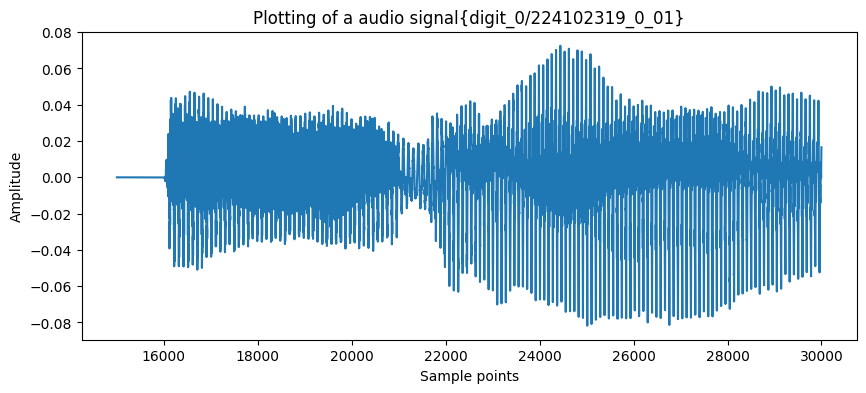

In [5]:
plt.figure(figsize=(10,4))
plt.plot(range(15000,30000),audio_signal[15000:30000])
plt.xlabel("Sample points")
plt.ylabel("Amplitude")
plt.title("Plotting of a audio signal{digit_0/224102319_0_01}")
plt.show()

In [6]:
type(audio_signal)

numpy.ndarray

In [7]:
!nvidia-smi

Sun May 14 05:42:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Part-1:

### compute 39-dimensional MFCC features and learn a GMM having 16/32 densities for each of the isolated digits using training data

#### Extracting MFCC features using Librosa

Audio duration: 1.768 seconds
Shape of MFCC array: (177, 39)
MFCCs for the first frame: [-5.63362948e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.02830711e-14  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.47108845e-15  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]


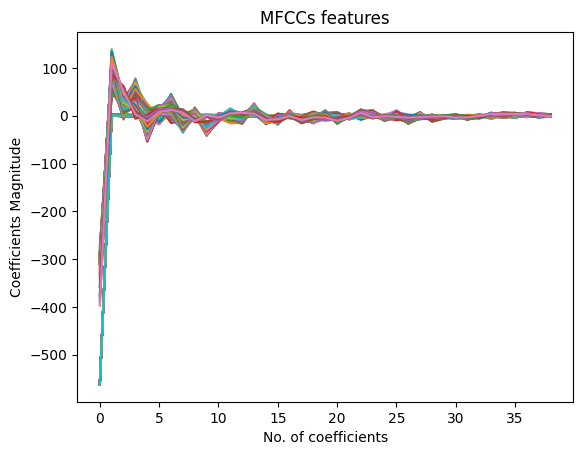

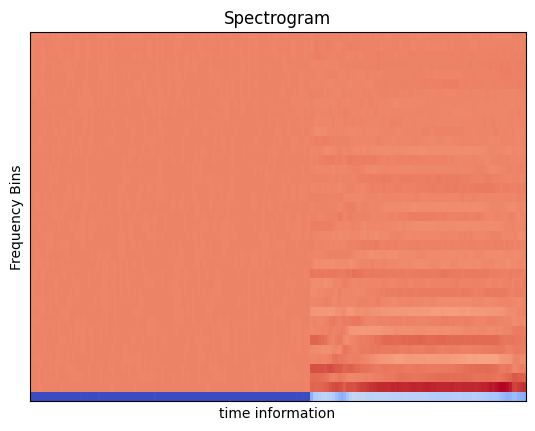

In [8]:
audio_signal, sampling_rate = soundfile.read(r"/content/drive/MyDrive/Speech_project/Recording_Shayan/digit_0/224102319_0_02.wav")

print('Audio duration: {} seconds'.format(audio_signal.size / sampling_rate))

# MFCC configuration:
# N_MFCC = 13
N_MFCC = 39
N_MELS = 40 
WINDOW_LENGTH = int(0.025 * sampling_rate)  # To obtain 25 ms window
HOP_LENGTH = int(0.010 * sampling_rate)  # 10 ms shift between consecutive windows

# Extracting MFCCs:
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=WINDOW_LENGTH, hop_length=HOP_LENGTH).T

print('Shape of MFCC array:', mfccs.shape)
print('MFCCs for the first frame:', mfccs[0, :])
plt.plot(mfccs.T);
plt.title("MFCCs features")
plt.ylabel("Coefficients Magnitude")
plt.xlabel("No. of coefficients")
plt.show()

plt.figure()
librosa.display.specshow(mfccs.T)
plt.title("Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("time information")
plt.show()

#### Feature normalization
Lets normalize features so that their mean and variance over time axis equals 0 and 1, respectively. This tends to be beneficial in classification tasks.

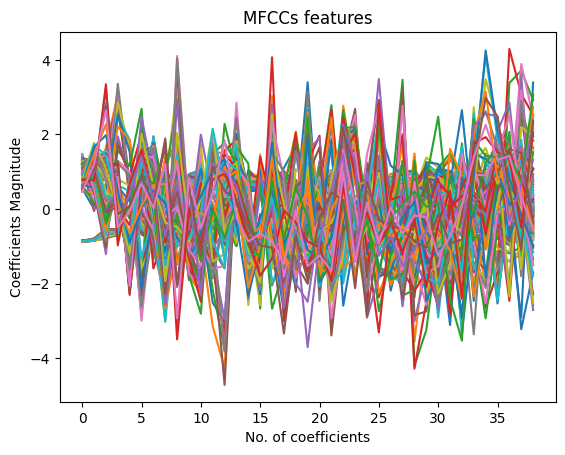

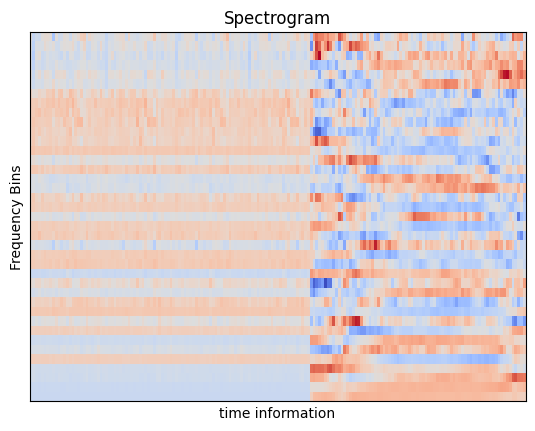

In [9]:
mfccs -= np.mean(mfccs, axis=0)
mfccs /= np.std(mfccs, ddof=0, axis=0)
plt.plot(mfccs.T);
plt.title("Normalized MFCCs features")
plt.title("MFCCs features")
plt.ylabel("Coefficients Magnitude")
plt.xlabel("No. of coefficients")
plt.show()

plt.figure()
librosa.display.specshow(mfccs.T)
plt.title("Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("time information")
plt.show()

#### Extracting normalized MFCCs for all files in the dataset

In the dataset, we have `250 audio files` (2 datasets one for `training` and another for `testing`, 10 digits, 20 repetitions for each digit in training set and 5 repetitions for each digit in testing set). 

For each each audio file we will get an array of MFCCs.

In [10]:
# Set paths for data and lists
data_path = r"/content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/"

##### MFCCs and GMM parameters

In [11]:
# Set the parameters for computing MFCCs and GMM
n_mfcc = 39
n_fft = 512
win_length = 480   # To obtain 30 ms window
hop_length = 160   # 10 ms shift between consecutive windows
n_components = 16

##### Defining function for feature-extraction, train_gmm and test_gmm

In [12]:
# Define a function to extract MFCC features from a file
def extract_features(file_path, n_mfcc=39, win_length = 480, hop_length = 160, n_fft = 512):
    audio_signal, sampling_rate = librosa.load(file_path, sr=16000)
    # Normalizing time domain signal:
    audio_signal = audio_signal / np.max(np.abs(audio_signal)) 
    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # Feature normalization:
    mfccs -= np.mean(mfccs, axis=0)
    mfccs /= np.std(mfccs, ddof=0, axis=0)
    return mfccs.T

# Define a function to train a GMM
def train_gmm(features, n_components):
    gmm = GaussianMixture(n_components=n_components, covariance_type='tied', max_iter=100, verbose=0)
    gmm.fit(features)
    return gmm

# Define a function to test a GMM
def test_gmm(gmm, features):
    scores = gmm.score_samples(features)
    return np.argmax(scores)

##### Extract Features and Train GMM

In [13]:
# Extract MFCC features from training data and train GMMs
keys = ['training', 'testing']
digits = ['digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']

gmms = {}
for digit in digits:
    # Define the folder path
    digit_folder = os.path.join(data_path, keys[0], digit)
    digit_files = [filename for filename in os.listdir(digit_folder)]
    digit_features = np.concatenate([extract_features(os.path.join(digit_folder, f), n_mfcc=39) for f in digit_files])
    gmm = train_gmm(digit_features, n_components)
    gmms[digit] = gmm


## Part-2:

### Identify the digits in test data using the maximum likelihood rule over the trained GMMs and report the confusion matrix for the recognition task.

#### Classify test data using maximum likelihood rule
Identify the digits in test data using the maximum likelihood rule over the trained GMMs

In [14]:
# Test the trained GMMs on the test data
true_labels = []
predicted_labels = []

for i,digit in enumerate(digits):
    # Define the folder path
    digit_folder = os.path.join(data_path, keys[1], digit)
    print(f"Inside folder: {digit_folder}")
    test_digit_files = [filename for filename in os.listdir(digit_folder)]
    print(f"Testing GMM on :\n {test_digit_files}\n")
    for test_file in test_digit_files:
        test_features = extract_features(os.path.join(digit_folder, test_file), n_mfcc=39)
        scores = [gmm.score(test_features) for gmm in gmms.values()]

        # # Classify test data using maximum likelihood rule
        predicted_digit = np.argmax(scores)
        true_digit = int(i)
        predicted_labels.append(predicted_digit)
        true_labels.append(true_digit)

print("\nGMM test done!\n")

Inside folder: /content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/testing/digit_0
Testing GMM on :
 ['224102319_0_21.wav', '224102319_0_22.wav', '224102319_0_23.wav', '224102319_0_24.wav', '224102319_0_25.wav']

Inside folder: /content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/testing/digit_1
Testing GMM on :
 ['224102319_1_21.wav', '224102319_1_22.wav', '224102319_1_23.wav', '224102319_1_24.wav', '224102319_1_25.wav']

Inside folder: /content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/testing/digit_2
Testing GMM on :
 ['224102319_2_21.wav', '224102319_2_22.wav', '224102319_2_23.wav', '224102319_2_24.wav', '224102319_2_25.wav']

Inside folder: /content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/testing/digit_3
Testing GMM on :
 ['224102319_3_21.wav', '224102319_3_22.wav', '224102319_3_23.wav', '224102319_3_24.wav', '224102319_3_25.wav']

Inside folder: /content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/testing/digit_4


#### Report the confusion matrix for the recognition task

In [15]:
# Compute and print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels, labels=list(range(10)))
print('Confusion matrix:')
print(confusion_mat)


Confusion matrix:
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 1 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 1 4 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


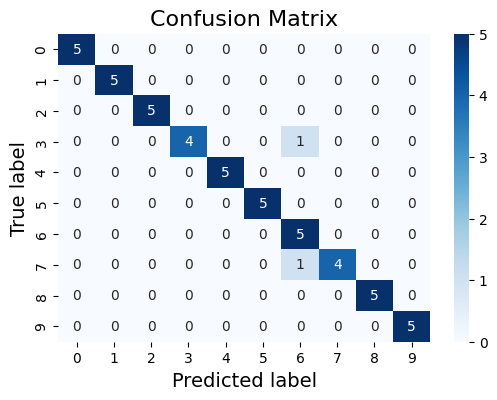

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', 
            xticklabels=range(10), yticklabels=range(10), ax=ax)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

#### Classification Report:

In [17]:
from sklearn.metrics import classification_report

target_names = ['Digit 0', 'Digit 1', 'Digit 2', 'Digit 3', 'Digit 4', 'Digit 5', 'Digit 6', 'Digit 7', 'Digit 8', 'Digit 9']
print(classification_report(true_labels, predicted_labels, labels=list(range(10)), target_names=target_names))


              precision    recall  f1-score   support

     Digit 0       1.00      1.00      1.00         5
     Digit 1       1.00      1.00      1.00         5
     Digit 2       1.00      1.00      1.00         5
     Digit 3       1.00      0.80      0.89         5
     Digit 4       1.00      1.00      1.00         5
     Digit 5       1.00      1.00      1.00         5
     Digit 6       0.71      1.00      0.83         5
     Digit 7       1.00      0.80      0.89         5
     Digit 8       1.00      1.00      1.00         5
     Digit 9       1.00      1.00      1.00         5

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.97      0.96      0.96        50



## END of the Project.

Save Mfcc fetaures in G-Drive and load it:

In [ ]:
# import pickle

# # Define the filename and path to save the mfcc_features dictionary
# filename = r'/content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/mfcc_features.pkl'

# # Save the mfcc_features dictionary to the file using the pickle module
# with open(filename, "wb") as file:
#     # Serialize and save the dictionary to the file
#     pickle.dump(mfcc_features, file)

In [ ]:
# # Define the file path
# file_path = r'/content/drive/MyDrive/Speech_project/Recording_Shayan/project_2/mfcc_features.pkl'

# # Open the file in read mode
# with open(file_path, "rb") as file:
#     # Deserialize the dictionary from the file
#     mfcc_features = pickle.load(file)

END